# Time Fronts
generate figure 2

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bighorn
import seaborn as sns
from kaooi.coordinates import coords, depths
from matplotlib.colorbar import ColorbarBase
import cmps
from dotenv import load_dotenv
import os

# load .env file
env_path = '../.env'
_ = load_dotenv(env_path)

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

/gscratch/coenv/jhrag/miniconda/envs/kb/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Load timefronts

In [3]:
hydrophones = ['AXBA1','AXEC2','AXCC1','HYS14','LJ01C','LJ01A']
gts_climate_d = {}
for node in hydrophones:
    fnr = f'{os.environ["data_directory"]}timefront/iw_climate_{node}_Gfz_real.nc'
    fni = f'{os.environ["data_directory"]}timefront/iw_climate_{node}_Gfz_imag.nc'

    gf = xr.open_dataarray(fnr) + 1j*xr.open_dataarray(fni)
    gt = bighorn.convert_to_time(gf, 300, 10, (37.5, 112.5))
    gts_climate_d[node] = 20*np.log10(np.abs(gt))
gts_climate = xr.Dataset(gts_climate_d)

In [4]:
hydrophones = ['AXBA1','AXEC2','AXCC1','HYS14','LJ01C','LJ01A']
gts_climate_iw_d = {}
for node in hydrophones:
    fnr = f'{os.environ["data_directory"]}timefront/climate_{node}_Gfz_real.nc'
    fni = f'{os.environ["data_directory"]}timefront/climate_{node}_Gfz_imag.nc'

    gf = xr.open_dataarray(fnr) + 1j*xr.open_dataarray(fni)
    gt = bighorn.convert_to_time(gf, 300, 10, (37.5, 112.5))
    gts_climate_iw_d[node] = 20*np.log10(np.abs(gt))
    
gts_climate_iw = xr.Dataset(gts_climate_iw_d)

## Create Plot

In [5]:
cmap = cmps.rocket_r_white()

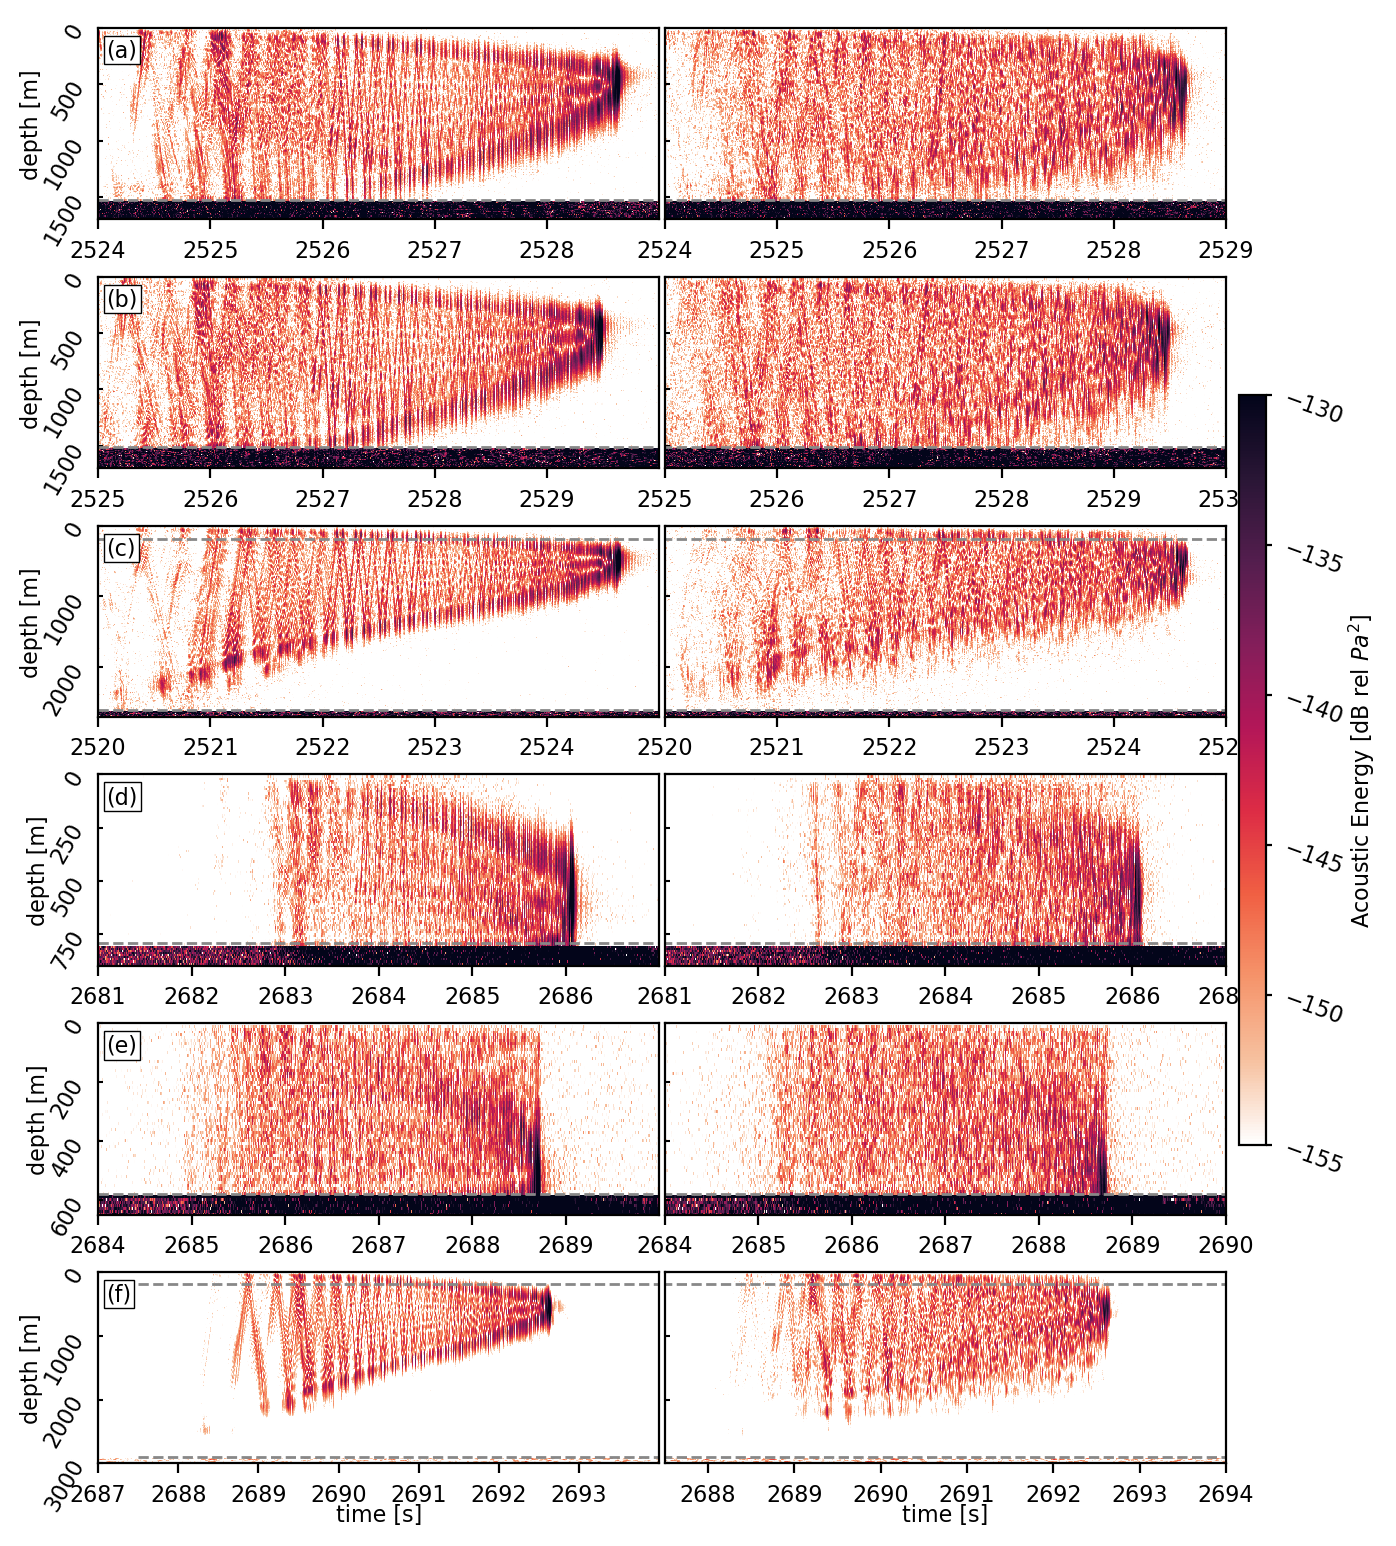

In [10]:
ylims = {
    'AXCC1':(1700,0),
    'AXEC2':(1700,0),
    'AXBA1':(2700,0),
    'LJ01A':(3000,0),
    'LJ01C':(650,0),
    'LJ01D':(100,0),
    'HYS14':(900,0),
}
xlims = {
    'AXCC1':(4, 9),
    'AXEC2':(5,10),
    'AXBA1':(0, 5),
    'LJ01A':(7.5, 14),
    'LJ01C':(4, 10),
    'LJ01D':(0, 10),
    'HYS14':(1, 7),
}

titles = {
    'AXCC1':'AXCC1, AXEC2',
    'AXBA1':'AXBA1, LJ03A, PC03A',
    'LJ01A':'LJ01A, HYS1B, PC01A',
    'LJ01C':'LJ01C',
    'LJ01D':'LJ01D',
    'HYS14':'HYS14',
}

fs_integer = {
    'AXCC1':252,
    'AXEC2':252,
    'AXBA1':252,
    'LJ01C':268,
    'PC01A':267,
    'PC03A':252,
    'HYS14':268,
    'LJ01A':268,
}

xlims_abs = {}
for node in hydrophones:
    xlims_abs[node] = (xlims[node][0] + fs_integer[node]*10, xlims[node][1] + fs_integer[node]*10)

plt.rcParams.update({'font.size':8})
fig, axes = plt.subplots(6,2, figsize=(6.67,7.5))

letters = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)']

hydrophones_plot = ['AXCC1','AXEC2','AXBA1','HYS14','LJ01C','LJ01A']
# add letters
for k, ax in enumerate(axes[:,0].flatten()):
    ax.text(
        0.015,
        0.85,
        letters[k],
        transform=ax.transAxes,
        fontsize=8,
        zorder=100,
        bbox=dict(facecolor='white', edgecolor='k', pad=1, linewidth=0.5)
    )

# make ticks be inside plot
for ax in axes.flatten():
    ax.tick_params(axis='y', direction='in', length=1.8, width=0.75)
        
# remove y labels from second row
for k, ax in enumerate(axes[:,1].flatten()):
    ax.set_yticklabels('')

# Plot climate wavefronts
for k, ax in enumerate(axes[:,0].flatten()):
    node = hydrophones_plot[k]
    plt.sca(ax)
    gts_plot = gts_climate[node].assign_coords({'time':gts_climate[node].time+fs_integer[node]*10})
    climate_plot = gts_plot.plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
    if node == 'LJ01A': # Plot time [10,20]
        gts_plot.assign_coords({'time':gts_plot.time+10}).plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
        pass

    if node == 'HYS14':
        plt.hlines(depths['HYS14']+20, xlims_abs[node][0],xlims_abs[node][1], color='#888888', alpha=1, linestyle='--', lw=1)
    else:
        plt.hlines(depths[node], xlims_abs[node][0],xlims_abs[node][1], color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'AXBA1':
        plt.hlines(depths['PC03A'], xlims_abs[node][0],xlims_abs[node][1], color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'LJ01A':
        plt.hlines(depths['PC01A'], xlims_abs[node][0],xlims_abs[node][1], color='#888888', alpha=1, linestyle='--', lw=1)

    if k == 5:
        plt.xlabel('time [s]', labelpad=-1)
    else:
        plt.xlabel('')
        
    plt.ylabel('depth [m]', labelpad=-1)
    plt.ylim(ylims[node])
    plt.xlim(xlims_abs[node])
    plt.yticks(rotation=60)

# Plot climate + IW wavefronts
for k, ax in enumerate(axes[:,1].flatten()):

    node = hydrophones_plot[k]
    
    plt.sca(ax)
    gts_plot = gts_climate_iw[node].assign_coords({'time':gts_climate_iw[node].time+ fs_integer[node]*10})
    climate_iw_plot = gts_plot.plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
    if node == 'LJ01A': # Plot time [10,20]
        gts_plot.assign_coords({'time':gts_plot.time+10}).plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
        pass
        
    if k == 5:
        plt.xlabel('time [s]', labelpad=-1)
    else:
        plt.xlabel('')
    plt.ylabel('')
    plt.ylim(ylims[node])
    plt.xlim(xlims_abs[node])
    plt.yticks(rotation=60)

    if node == 'HYS14':
        plt.hlines(depths['HYS14']+20, xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    else:
        plt.hlines(depths[node], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'AXBA1':
        plt.hlines(depths['PC03A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'LJ01A':
        plt.hlines(depths['PC01A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)

# remove last xtick label
for ax in axes[:,0].flatten():
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[:-1])

plt.tight_layout(pad=0)
fig.subplots_adjust(right=0.9, hspace=0.3, wspace=0.01)
ax_cbar = fig.add_axes((0.91, 0.25, 0.02, 0.5))
norm = plt.Normalize(vmin=-155, vmax=-130)
# Create the colorbar using a standard colormap
cbar = ColorbarBase(
    ax_cbar,
    cmap=cmap,  # You can change this to any standard colormap
    norm=norm,
)
cbar.set_label(label=r'Acoustic Energy [dB rel $Pa^2$]', labelpad=0)
# Rotate tick labels and make ticks shorter
cbar.ax.tick_params(labelrotation=-20, length=2)  # length controls tick size

fig.savefig('figures/timefronts.pdf', bbox_inches='tight', dpi=500)
#plt.close()
#ax_bounds = fig.add_axes([0,0,1,1])
#ax_bounds.set_xticks([])
#ax_bounds.set_yticks([])
#ax_bounds.set_facecolor('#00000000')
